In [46]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [8]:
  !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt   #type: ignore

--2024-07-18 17:33:33--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-07-18 17:33:33 (6.39 MB/s) - ‘names.txt’ saved [228145/228145]



In [9]:
words = open("names.txt", 'r').read().splitlines() #type: ignore

In [10]:
len(words)

32033

In [11]:
chars = sorted(list(set(''.join(words))))
str_to_int = {s: i+1 for i, s in enumerate(chars)}
str_to_int['.'] = 0
int_to_str = {i: s for s, i in str_to_int.items()}
int_to_str

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [27]:
block_size = 3 # context length -> how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = str_to_int[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
Xtr[0]

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


tensor([0, 0, 0])

In [85]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g) # because we have a character level model, we embed each character so we have 27 rows for each possible character, 10 is just the embedding dimension
W1 = torch.randn((block_size * C.shape[1], 200), generator=g) / math.sqrt(2/(block_size * C.shape[1]))# 30 because we want to feed in 3 characters
b1 = torch.zeros((200,))
W2 = torch.randn((200, 27), generator=g) + 0.00001 / math.sqrt(2/200)
b2 = torch.zeros((27,))
parameters = [C, W1, b1, W2, b2]

In [86]:
sum(p.nelement() for p in parameters) # sum of parameters in total

18167

In [87]:
for p in parameters:
  p.requires_grad = True

In [88]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [89]:
lri = []
lossi = []
stepi = []

In [90]:
for i in range(30000):

  #minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))

  #forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
  # print(h.shape, W2.shape, b2.shape)
  logits = h @ W2 + b2
  # print(logits.sum())
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())
print(loss.item())

2.3919904232025146


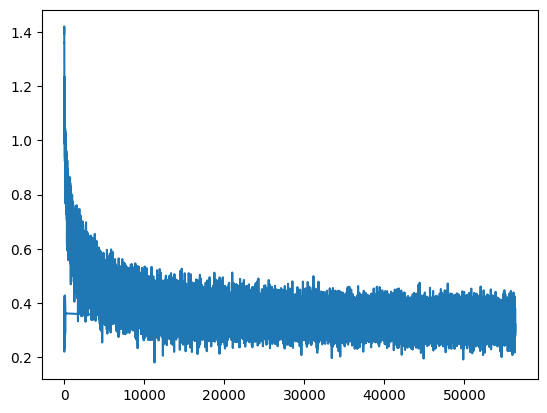

In [37]:
plt.plot(stepi, lossi)

In [73]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1) # (32, 10)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3012, grad_fn=<NllLossBackward0>)

In [74]:
# validation/dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3324, grad_fn=<NllLossBackward0>)

In [75]:
# training loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.3421, grad_fn=<NllLossBackward0>)

In [76]:
# Increased batch size
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1) # (32, 10)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss)

# validation/dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss)

tensor(2.3012, grad_fn=<NllLossBackward0>)
tensor(2.3324, grad_fn=<NllLossBackward0>)


In [24]:
vec = torch.ones((182625, 27))

In [25]:
vec = vec / vec.sum(dim=1, keepdim=True)

In [26]:
F.cross_entropy(vec, Ytr)
# logits.shape

tensor(3.2958)